## Application à MNIST

In [46]:
import torch
import matplotlib.pyplot as plt
plt.ion()
import numpy as np
import scipy.io
import torch.optim as optim
from torch.utils.data import Dataset

In [47]:
def init_model(nx, nh, ny, eta):
    model = torch.nn.Sequential(
        torch.nn.Linear(nx, nh),
        torch.nn.Tanh(),
        torch.nn.Linear(nh, ny),
        torch.nn.Softmax(dim=1)
    )
    loss_fn = torch.nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=eta)
    optimizer = optim.Adam(model.parameters(), lr=eta)

    return model, loss_fn, optimizer

def loss_accuracy(loss_function, Y_hat, Y):
    loss = loss_function(Y_hat, torch.argmax(Y, dim=1))
    _, predicted_labels = torch.max(Y_hat, 1)
    _, true_labels = torch.max(Y, 1)
    correct_predictions = (predicted_labels == true_labels).float().sum().item()
    total_samples = Y.size(0)
    accuracy = correct_predictions / total_samples

    return loss, accuracy

In [48]:
class MNISTData(Dataset):

    def __init__(self, file_path="../resources/data/mnist.mat"):
        self.file_path = file_path
        self._load_data()

    def _load_data(self):
        mnist = scipy.io.loadmat(self.file_path)
        self._Xtrain_th = torch.from_numpy(mnist["Xtrain"].astype('float32'))
        self._Xtest_th = torch.from_numpy(mnist["Xtest"].astype('float32'))
        self._Ytrain_th = torch.from_numpy(mnist["Ytrain"].astype('float32'))
        self._Ytest_th = torch.from_numpy(mnist["Ytest"].astype('float32'))

    @property
    def Xtrain(self):
        return self._Xtrain_th

    @property
    def Xtest(self):
        return self._Xtest_th

    @property
    def Ytrain(self):
        return self._Ytrain_th

    @property
    def Ytest(self):
        return self._Ytest_th

    def __len__(self):
        return len(self._Xtrain_th)

    def __getitem__(self, idx):
        return {
            'Xtrain': self._Xtrain_th[idx],
            'Xtest': self._Xtest_th[idx],
            'Ytrain': self._Ytrain_th[idx],
            'Ytest': self._Ytest_th[idx]
        }

N 60000
nx 784


C:\Users\ROG ZEPHYRUS\AppData\Local\Temp\ipykernel_19380\1222285437.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(Xtrain_split[indsBatch, :], dtype=torch.float32)
C:\Users\ROG ZEPHYRUS\AppData\Local\Temp\ipykernel_19380\1222285437.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Ytrain_split[indsBatch], dtype=torch.long)


Iter 0: Acc train 85.9%, Acc val 86.9%, Acc test 86.7% | Loss train 1.64, Loss val 1.64, Loss test 1.63
Iter 1: Acc train 87.3%, Acc val 87.3%, Acc test 88.2% | Loss train 1.62, Loss val 1.62, Loss test 1.61
Iter 2: Acc train 88.0%, Acc val 87.3%, Acc test 88.2% | Loss train 1.60, Loss val 1.61, Loss test 1.60
Iter 3: Acc train 87.5%, Acc val 87.5%, Acc test 88.1% | Loss train 1.60, Loss val 1.60, Loss test 1.60
Iter 4: Acc train 87.5%, Acc val 87.8%, Acc test 87.9% | Loss train 1.60, Loss val 1.60, Loss test 1.60
Iter 5: Acc train 87.9%, Acc val 87.6%, Acc test 88.4% | Loss train 1.60, Loss val 1.60, Loss test 1.60
Iter 6: Acc train 88.2%, Acc val 88.1%, Acc test 88.7% | Loss train 1.59, Loss val 1.59, Loss test 1.59
Iter 7: Acc train 88.8%, Acc val 88.5%, Acc test 89.2% | Loss train 1.58, Loss val 1.58, Loss test 1.58
Iter 8: Acc train 89.4%, Acc val 89.1%, Acc test 89.1% | Loss train 1.58, Loss val 1.58, Loss test 1.58
Iter 9: Acc train 89.4%, Acc val 88.8%, Acc test 89.0% | Loss tr

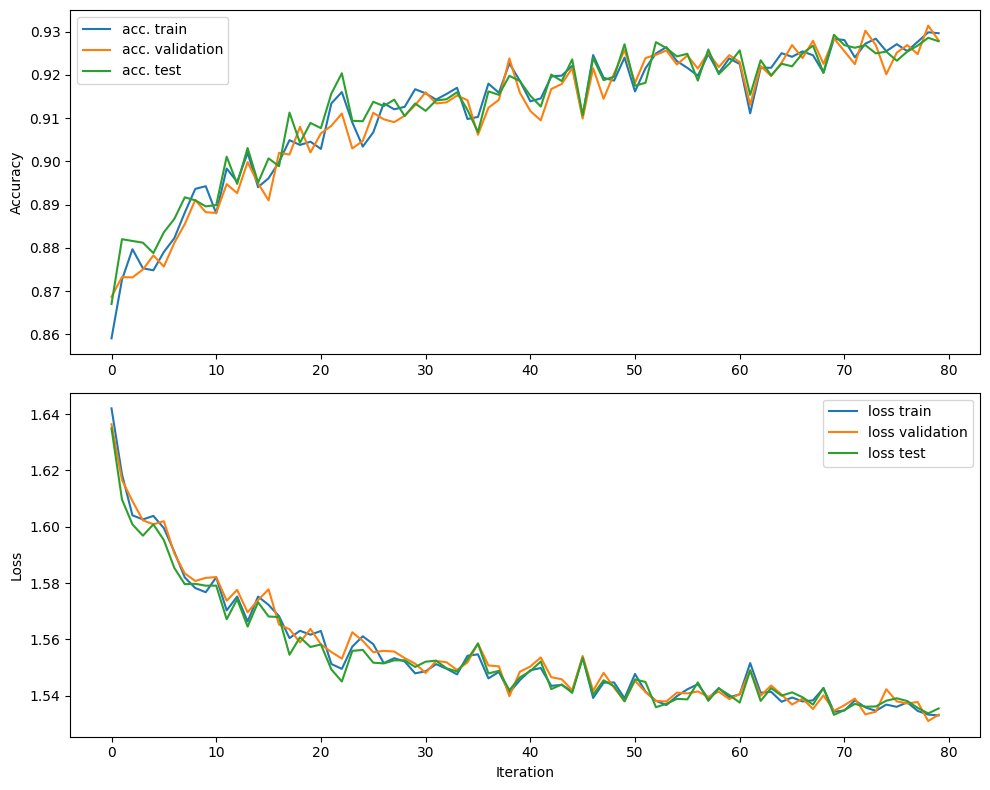

In [49]:
data = MNISTData()
N = data.Xtrain.shape[0]    # 60,000 samples
Nbatch = 32
nx = data.Xtrain.shape[1]   # 784 pixels
print("N", N)
print("nx", nx)
nh = 100
ny = 10
eta = 0.001
iter = 80

model, loss_fn, optimizer = init_model(nx, nh, ny, eta)

train_curves = [[], []]
val_curves = [[], []]
test_curves = [[], []]

for iteration in range(iter):
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm]

    split_ratio = 0.8
    split_idx = int(split_ratio * N)
    Xtrain_split, Xval_split = Xtrain[:split_idx, :], Xtrain[split_idx:, :]
    Ytrain_split, Yval_split = Ytrain[:split_idx], Ytrain[split_idx:]
    
    for j in range(split_idx // Nbatch):
        indsBatch = range(j * Nbatch, (j+1) * Nbatch)

        X = torch.tensor(Xtrain_split[indsBatch, :], dtype=torch.float32)
        Y = torch.tensor(Ytrain_split[indsBatch], dtype=torch.long)

        optimizer.zero_grad()

        y_hat = model(X)
        loss, accuracy = loss_accuracy(loss_fn, y_hat, Y)
        loss.backward()

        optimizer.step()

    for data_split, curves in zip([(Xtrain_split, Ytrain_split), (Xval_split, Yval_split), (data.Xtest, data.Ytest)], [train_curves, val_curves, test_curves]):
        X_eval, Y_eval = data_split
        Yhat_eval = model(X_eval)
        L_eval, acc_eval = loss_accuracy(loss_fn, Yhat_eval, Y_eval)
        curves[0].append(acc_eval)
        curves[1].append(L_eval)

    title = 'Iter {}: Acc train {:.1f}%, Acc val {:.1f}%, Acc test {:.1f}% | Loss train {:.2f}, Loss val {:.2f}, Loss test {:.2f}'.format(
        iteration, train_curves[0][-1] * 100, val_curves[0][-1] * 100, test_curves[0][-1] * 100,
        train_curves[1][-1], val_curves[1][-1], test_curves[1][-1]
    )
    print(title)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(train_curves[0], label="acc. train")
ax1.plot(val_curves[0], label="acc. validation")
ax1.plot(test_curves[0], label="acc. test")
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot([tensor.detach().numpy() for tensor in train_curves[1]], label="loss train")
ax2.plot([tensor.detach().numpy() for tensor in val_curves[1]], label="loss validation")
ax2.plot([tensor.detach().numpy() for tensor in test_curves[1]], label="loss test")

ax2.set_xlabel('Iteration')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()